C:\Users\gaura\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gaura\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gaura\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Decision tree classification accuracy:  0.9745454545454545


C:\Users\gaura\AppData\Local\Temp\ipykernel_19996\739591135.py:64: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self._pdf(idx, x)))


Naive Bayes classification accuracy 0.9945454545454545
KNN classification accuracy 0.9854545454545455


Text(0.5, 1.0, 'ACCURACY of different Classification Algorithms')

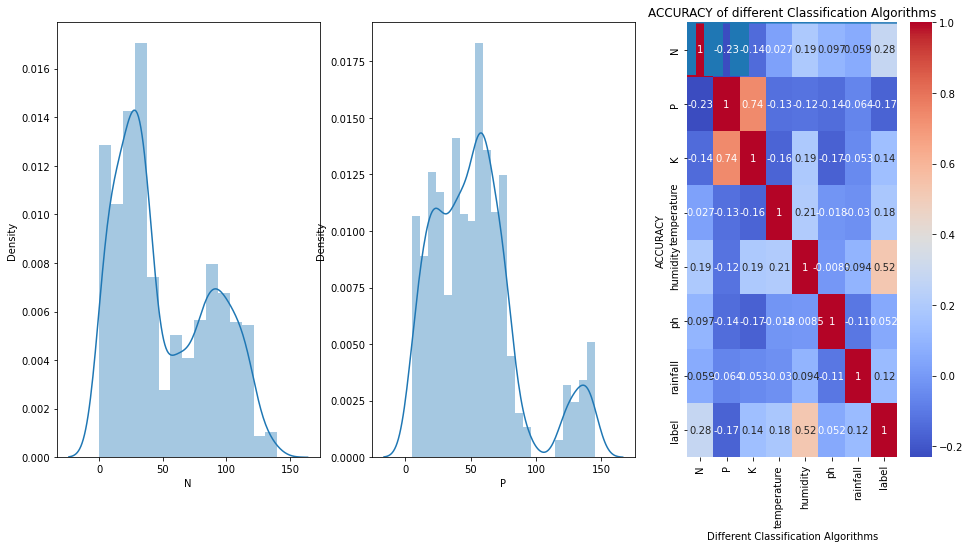

In [3]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[: self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # return the most common class label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]





class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator





def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common



def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

import pandas as pd
dataset = pd.read_csv('Crop_recommendation_new.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

fig, ax = plt.subplots(1,3,figsize=(16,8)) 
sb.distplot(dataset['N'],ax=ax[0]) 
sb.distplot(dataset['P'],ax=ax[1]) 
sb.distplot(dataset['K'],ax=ax[2])
#sb.distplot(dataset['temperature'],ax=ax[0]) 
#sb.distplot(dataset['humidity'],ax=ax[1]) 
#sb.distplot(dataset['ph'],ax=ax[2]) 
#sb.distplot(dataset['rainfall'],ax=ax[0]) 


sb.heatmap(dataset.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


dt = DecisionTree(max_depth=10)
dt.fit(X_train, y_train)
y_predictions1 = dt.predict(X_test)
acc = accuracy(y_test, y_predictions1)
print("Decision tree classification accuracy: ", acc)


nb = NaiveBayes()
nb.fit(X_train, y_train)
y_predictions3 = nb.predict(X_test)
acc2 = accuracy(y_test, y_predictions3)
print("Naive Bayes classification accuracy", accuracy(y_test, y_predictions3))


k = 3
kn = KNN(k=k)
kn.fit(X_train, y_train)
y_predictions2 = kn.predict(X_test)
acc3 = accuracy(y_test, y_predictions2)
print("KNN classification accuracy", accuracy(y_test, y_predictions2))

"""
N=int(input("Enter the N "))
P=int(input("Enter the P "))
K=int(input("Enter the K "))
temp=float(input("Enter the temperature "))
H=float(input("Enter the humidity "))
ph=float(input("Enter ph "))
rain=float(input("Enter the rainfall "))
X_new=np.array([[N],[P],[K],[temp],[H],[ph],[rain]]).reshape(1,7)

X_new=sc.transform(X_new)


y_pred1=dt.predict(X_new)
y_pred2=nb.predict(X_new)
y_pred3=kn.predict(X_new)


print(y_pred1," ",y_pred2," ",y_pred3)

predict_cmn=[y_pred1[0],y_pred2[0],y_pred3[0]]

import statistics
from statistics import mode

vector_nam=["rice","maize","chickpea","kidneybeans","pigeonpeas","mothbeans","mungbeans","blackgram","lentil","pomengranate","banana",
"mango","grapes","watermelon","muskmelon","apple","orange","papaya","coconut","cotton","jute","coffee"]

print(vector_nam[mode(predict_cmn)])

"""

y_axis=np.array([acc,acc2,acc3])
x_axis=np.array(["Decison Tree","Naive Bayes","KNN"])

from matplotlib import pyplot as plt
plt.bar(x_axis,y_axis,width=.7);
plt.xticks(rotation = 90)
plt.xlabel("Different Classification Algorithms")
plt.ylabel("ACCURACY")
plt.title("ACCURACY of different Classification Algorithms")